# CTMCs in Epidemic Behavior

Ardenghi Alessandro (3144656)

Zoccante Andrea (3150188)

## Abstract

Our aim with this project is to model the development of an epidemic through various Continuous Time Markov Chains (CTMCs), all of which will be based on the classic SIR model. Such model in particular features 3 interacting populations, namely the _susceptible_ (S) population, the _infected_ (I) population, and the _recovered_ (R) population.

The first part of the project will feature a toy implementation of the SIR model with no fading immunity, and afterwards we will sequentially introduce greater degrees of realism into the model. This will be achieved by progressively modifying the structure of our CTMCs in order to incorporate real-world complexities such as gradual loss of immunity, implementation of lockdown measures and adaptive lockdown stragegies, with the aim of mimicking real-life public health policies.

Throughout our project, we will employ the Gillespie Algorithm in order to precisely generate CTMCs, and our final goals will be to analyze the effect that different rates have on the MC behaviors, as well as what kind of limiting behavior is displayed.

___

## Libraries

In [ ]:
import numpy as np
from sys import exit
import random as rnd
from math import log
import matplotlib.pyplot as plt
from statistics import mean
import random
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, widgets
from scipy.optimize import curve_fit



---



## Theoretical Framework

As explained in the abstract, in this notebook we will implement some CTMCs to model the behavior of an epidemic under different scenarios, and we will investigate how changing the parameters (rates) of the model affects the behavior of the MC, as well as what kind of limiting behavior such MCs will display.

In order to perform such tasks, we will implement Gillespie Algorithm to exactly generate some CTMC.

The implementation of the algorithm is divided into the following steps:


1.   Initialization: $X(0) = X_0, \quad t = 0$
2.   Computation of the rates $a_r(X(t))$ and of the exponential rate of the holding time $a_0 = \sum_{r}{a_r(X(t))}$
3. Generation of the waiting time $\tau \sim Exp(a_0) $
4. Random choice of a reaction with probability $ K_r = \frac{a_r}{\sum_{r'}a_{r'}} $
5. Time Update with $t = t + \tau$ and Variable Update depending on the chosen reaction
6. Repeat from 2 until the desired time lenght is reached



---




## Algorithm Implementation



Our implementation of Gillespie Algorithm is performed through the use of some functions which be describe in detail below. In general, steps *1*, *3*, *5* and *6* of the algorithm are performed by the _vectorized_gillespie_ function, whereas the choice of the reaction (step *4*) will be performed by the _random_choice_ function. Step 2 will instead be computed by the _vectorized_propensities_ function, which we will modify each time to accomodate new models.

Let us describe more precisely what each function does:
- vectorized_gillespie(): takes as input the following quantities:

  - a vector which represents the initial state of the CTMC ($X_0$)
  - a list which includes the rates for the model
  - a scalar which represents the desired number of runs
  - a scalar which represents the desired number of iterations per run

  This function performs the steps $1, 3, 5, 6$ of the Gillespie Algorithm, and it also keeps track of the statistics of the MC.
  Let us remark that this function is very versatile, since it can take as input vectors of any lenght (thus we can have $X_0 \in \mathbb{R}^N$ for arbitrary N), as well as rates vectors of arbitrary length.

- random_choice(): takes as input a vector featuring the exponential rate of $T$ (which we denoted with $a_0$) and all the rates ($a_r$), and returns a reaction chosen randomly according to $K_r$

- vectorized_propensities(): takes as input a vector representing the current state of the MC ($X$) and a vector of rates for the model. This function performs step *2* of the algorithm, and computes the rates of the model.

- vectorized_postprocess(): takes as input the initial state, as well as the results of the runs of the Gillespie Algorithm obtaines through the _vectorized_gillespie_ function, and outputs the mean for each time bin

- reaction(): takes as input a scalar value (the reaction number) and returns the updates which follow the reaction

It is worth pointing out that, in order to define a new model, we will only modify the _vectorized_propensities_ function, because all the other ones do not need modifications to work with different models.



In [ ]:
n_bins = 20

In [ ]:
def random_choice(a):


    total_prob = a[0]
    probabilities = [p / a[0] for p in a[1:]]

    random_num = random.random()

    accumulated_prob = 0
    reaction_n = 0
    for elem, prob in zip(a[1:], probabilities):
        reaction_n += 1
        accumulated_prob += prob
        if random_num <= accumulated_prob:
            return reaction_n

    raise ValueError("Probabilities do not sum up to 1")

In [ ]:
# Before running fix X_0 and the rates in vector form. Make sure that the vector of rates matches the one used in the propensity function

def vectorized_gillespie(X_0, rates, total_runs, total_time):

  # Initialization
  tracker = [[[] for i in range(n_bins + 1)] for j in range(len(X_0))]                   #Array to collect statistics
  t = [[] for i in range(n_bins + 1)]
  rnd.seed(42)
  bin_size = total_time/ n_bins                                                          #Setting the random seed


  for run in range(total_runs):

    # Setting the initial conditions
    X = X_0
    time = 0
    step = 0

    while time < total_time:

        a = vectorized_propensities(X, rates)
        if a[0] == 0:
          break

        tau = - log( rnd.random() ) / a[0]

        react = random_choice( a )
        dX = reaction( react )
        X = [sum(pair) for pair in zip(X, dX)]

        time = time + tau
        step = step + 1

        bin = int(time/bin_size)
        if bin > n_bins:
          bin = n_bins

        for i in range(len(X_0)):
          tracker[i][bin].append(X[i])
        t[bin].append(time)


    return tracker, t

In [ ]:
def vectorized_postprocess(averages, time, X_0):


  means = [[] for i in range(len(averages))]
  mean_time = []
  mean_time.append(0)

  for i in range(len(X_0)):
    means[i].append(X_0[i])


  for i in range(n_bins + 1):

    #print(i)

    if len(averages[0][i]) != 0:

      for j in range(len(averages)):
        #print(j)
        means[j].append(mean(averages[j][i]))

      mean_time.append(mean(time[i]))

  return means, mean_time



---



## First Implementation: Toy Model

Our first step towards creating an epidemiological model is through the following model. We will model 3 interacting populations, which are the "susceptible" (S) population, the "infected" (I) population, and the "recovered" (R) population. In such model susceptible people can be infected, and infected people can recover, but once recovered people have full (and long-lasting) immunity from the disease, and thus cannot become susceptible again. We do not include in the model immigration, deaths and births, as it would make the model unnecessarily complicated, and thus the total population will remain constant over time (total population = TOT).

Let us describe the model formally:
- $X(t) = (X_S(t), X_I(t), X_R(t))$ with $\sum_{k}{X_k(t)} = TOT \quad \forall t, \quad k \in \{{S, I, R}\}$
- $\alpha$ = infection rate per susceptible person per infected person
- $\beta$ = recovery rate per infected person
- $Q_{(i, j, k)(i', j', k')} =
  \begin{cases}
    \alpha  X_S  X_I & \text{if  } (i', j', k') = (i-1, j+1, k) \\
    \beta X_I & \text{if  } (i', j', k') = (i, j-1, k+1) \\
    0 & otherwise
  \end{cases} $


### Initialization

In this very small subsection, we encode the relevant information of our model.

In [ ]:
# Propensities Vectorized

def vectorized_propensities(X, rates):


   #Initilization of propensities list
    a = [ 0. ] * (len(rates) + 1)


    a[1] = X[0] * X[1] * rates[0]     # Reaction from S --> I
    a[2] = X[1] * rates[1]            # Reaction from I --> R

    a[0] = sum(a[1:])                 # Computation of a
    return a

In [ ]:
def reaction(react):

    ds = 0
    di = 0
    dr = 0

    if react == 1:                   # Reaction 1 --> Infection
      ds = -1
      di = +1
    elif react == 2:                 # Reaction 2 --> Recovery
      di = -1
      dr = 1

    else: exit("* Wrong reaction tipe")
    X = [ds, di, dr]
    return X

### Exploration

In this subsection, we set up an interactive function which will allow us to efficiently explore different combinations of parameters and population sizes.

In [ ]:
n_bins = 100

def update_graph(parameter1, parameter2, parameter3):

    rates = [parameter1, parameter2]
    averages, time = vectorized_gillespie([int(0.95 * parameter3), parameter3 - int(0.95 * parameter3), 0], rates, 10, 200)
    final, final_time = vectorized_postprocess(averages, time, [int(0.95 * parameter3), parameter3 - int(0.95 * parameter3), 0])
    fig, ax = plt.subplots()

    ax.plot(final_time, final[0], label='s')
    ax.plot(final_time, final[1], label='i')
    ax.plot(final_time, final[2], label='r')
    ax.set_xlabel('Time')
    ax.set_ylabel('# of People')
    ax.legend()
    plt.title(f'alpha = {parameter1}, beta = {parameter2}, Population = {parameter3}')
    plt.show()


# Creation of the interactive dropdown menus for the parameters
slider1 = widgets.FloatSlider(value=0.010, min=0.000, max=0.020, step=0.001, description= 'Alpha:')
slider2 = widgets.FloatSlider(value=0.010, min=0.000, max=0.200, step=0.001, description= 'Beta:')
slider3 = widgets.FloatSlider(value=1000, min=0, max=10000, step=100, description= 'Population:')

# Connection of the dropdown menus to the update function
interact(update_graph, parameter1=slider1, parameter2=slider2, parameter3=slider3)



interactive(children=(FloatSlider(value=0.01, description='Alpha:', max=0.02, step=0.001), FloatSlider(value=0…

<function __main__.update_graph(parameter1, parameter2, parameter3)>

### Analysis

In this subsection, we provide a deep analysis of how different rates affect the dynamic of the model. More specifically, we will keep a constant population ($TOT = 1000$, $X_0 = (950, 50, 10)$), and we will first try to explore the effect that increasing the infection rate ($\alpha$) has on the MC (while keeping the recovery rate $\beta$ constant), and then we will do the opposite.

The Gillespie Algorithm will perform 10 different runs of 5000 iterations each (unless the rates become zero, in which case the algorithm will simply stop)

Let us remark that in the interest of brevity, throughout the project we will informally call $\alpha$ the "infection rate" and $\beta$ the recovery rate, instead of "infection rate per susceptible per infected person" and "recovery rate per infected person".

In [ ]:
def rates_comparison(list_rate):
    n = len(list_rate)
    averages = np.zeros(n).tolist()
    final = np.zeros(n).tolist()
    final_time = np.zeros(n).tolist()
    nrows = (n + 2) // 3
    fig, axes = plt.subplots(nrows= nrows, ncols= 3, figsize=(12, 3 * nrows))
    for i in range(n):
      if len(list_rate[0]) == 2:
        averages[i], time = vectorized_gillespie(X_0, list_rate[i], 10, 5000)
        final[i], final_time[i] = vectorized_postprocess(averages[i], time, X_0)
      else:
        averages[i], time = vectorized_gillespie(X_0, list_rate[i], 10, 500)
        final[i], final_time[i] = vectorized_postprocess(averages[i], time, X_0)
      axes[i // 3, i % 3].plot(final_time[i], final[i][0], label='s')
      axes[i // 3, i % 3].plot(final_time[i], final[i][1], label='i')
      axes[i // 3, i % 3].plot(final_time[i], final[i][2], label='r')
      axes[i // 3, i % 3].set_xlabel('Time')
      axes[i // 3, i % 3].set_ylabel('# of People')
      axes[i // 3, i % 3].legend()
      if len(list_rate[0]) == 2:
        axes[i // 3, i % 3].set_title(f"alpha = {list_rate[i][0]}, beta = {list_rate[i][1]}")
      else:
        axes[i // 3, i % 3].set_title(f"alpha = {list_rate[i][0]}, beta = {list_rate[i][1]}, gamma = {list_rate[i][2]}")

    plt.tight_layout()
    plt.show()

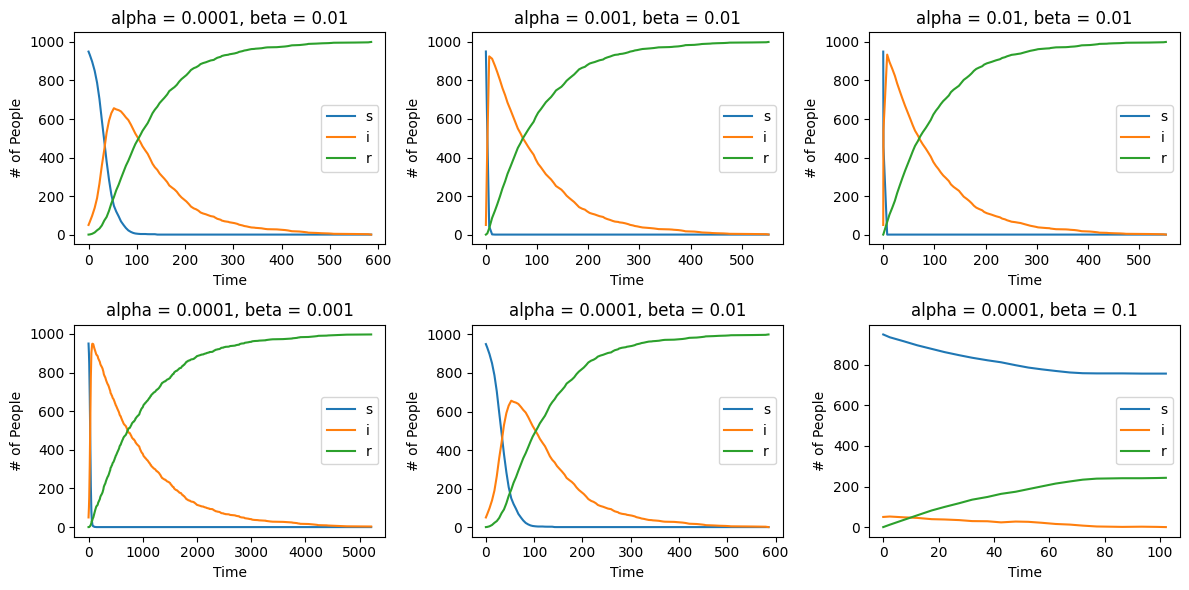

In [ ]:
population = 1000
list_rate = [[0.0001, 0.01], [0.001, 0.01], [0.01, 0.01],
             [0.0001, 0.001], [0.0001, 0.01], [0.0001, 0.1]]
X_0 = [int(0.95 * population), population - int(0.95 * population), 0]
n_bins = 1000

rates_comparison(list_rate)

Let us analyze these graphs:

- in the first row, we maintain a fixed recovery rate ($\beta =  0.01$) and experiment with varying values of the infection rate. We observe that when the infection rate ($\alpha$) is greater than or equal to 0.001, almost the entire population becomes infected immediately. However, with $\alpha = 0.0001$, we observe a more realistic scenario, which is depicted by a smoother curve for the infected population. The reason for which the two rates differ by 2 orders of magniture is that the actual infection rate is obtained as $\alpha X_S(t)X_I(t)$ (thus through a double product), whereas the recovery rate is computed as $\beta X_I(t)$. We shall remark that the infection rate not only impacts the velocity with which the peak of infections is reached, but also the magnitude of such peak.

- In contrast, in the second row, we keep the infection rate constant ($\alpha =  0.001$) and experiment with varying values of the recovery rate. When the recovery rate ($\beta$) is set to 0.1, we observe that the infection rate is nearly suppressed. Conversely, with $\beta$ set to 0.001, the effect of the infection rate is amplified, causing the entire population to become infected and taking a long time to recover. Interestingly, with $\beta$ set to 0.01, we observe a more realistic scenario where the epidemic is terminated within a reasonable time frame. Indeed, we shall remark that all this simulations took very different times, with the one with $\beta = 0.001$ taking almost 5000 iterations to converge to its limiting distribution, whereas the other two simulations took respectively roughly 600 and 100 iterations.

Overall, as we would expect, in this first model an increase in the infection rate causes the population to become infected in shorter time, and causes also many more people to become infected. On the other hand, an increase in the recovery rate causes the peak number of infected people to decrease, up until the point when there is no peak and only a small fraction of the population gets infected before the epidemic is debelled.



---



## Second Model: A more realistic perspective

The second model which we have decided to study is an extension of the previous one, but in order to portrait a more realistic scenario, we have decided to take into account the fact that immunity tends to fade over time, leaving people exposed to diseases which they contracted before.

Let us describe formally this new model:
- $X(t) = (X_S(t), X_I(t), X_R(t))$ with $\sum_{k}{X_k(t)} = TOT \quad \forall t, \quad k \in \{{S, I, R}\}$
- $\alpha$ = infection rate per susceptible person per infected person
- $\beta$ = recovery rate per infected person
- $\gamma$ = susceptibility rate (more specifically rate at which recovered people become susceptible again) per recovered person
- $Q_{(i, j, k)(i', j', k')} =
  \begin{cases}
    \alpha  X_S  X_I & \text{if  } (i', j', k') = (i-1, j+1, k) \\
    \beta X_I & \text{if  } (i', j', k') = (i, j-1, k+1) \\
    \gamma X_R & \text{if  } (i', j', k') = (i + 1, j, k-1) \\
    0 & otherwise
  \end{cases} $

### Initialization

In [ ]:
def reaction(react):

    ds = 0
    di = 0
    dr = 0

    if react == 1:
      ds = -1
      di = +1
    elif react == 2:
      di = -1
      dr = 1
    elif react == 3:
      ds = +1
      dr = -1

    else: exit("* Wrong reaction tipe")
    X = [ds, di, dr]
    return X

In [ ]:
def vectorized_propensities(X, rates):


   #Initilization of propensities list
    a = [ 0. ] * (len(rates) + 1)


    a[1] = X[0] * X[1] * rates[0]     # Reaction from S --> I
    a[2] = X[1] * rates[1]            # Reaction from I --> R
    a[3] = X[2] * rates[2]            # Reaction from R --> S

    a[0] = sum(a[1:])                 # Computation of a
    return a

### Exploration

As in the previous model, we introduce a function to perform an exploration of the model with different parameters. The population will be allowed to vary but the proportion of S, I, R will remain 95/5/0.

Furthermore, the Gillespie Algorithm will perform 10 runs of 200 iterations each.

In [ ]:
n_bins = 100

def update_graph_2(parameter1, parameter2, parameter3, parameter4):
    rates = [parameter1, parameter2, parameter3]
    averages, time = vectorized_gillespie([int(0.95 * parameter4), parameter4 - int(0.95 * parameter4), 0], rates, 10, 200)
    final, final_time = vectorized_postprocess(averages, time, [int(0.95 * parameter4), parameter4 - int(0.95 * parameter4), 0])
    fig, ax = plt.subplots()

    ax.plot(final_time, final[0], label='s')
    ax.plot(final_time, final[1], label='i')
    ax.plot(final_time, final[2], label='r')
    ax.set_xlabel('Time')
    ax.set_ylabel('# of People')
    ax.legend()
    plt.title(f'Graph with I.R. = {parameter1}, R.R. = {parameter2}, S.R.  = {parameter3}, Population = {parameter4}')
    plt.show()


# Creation of the interactive dropdown menus for the parameters
slider1 = widgets.FloatSlider(value=0.010, min=0.000, max=0.020, step=0.001, description= 'Alpha:')
slider2 = widgets.FloatSlider(value=0.010, min=0.000, max=0.200, step=0.001, description= 'Beta:')
slider3 = widgets.FloatSlider(value=0.010, min=0.000, max=0.200, step=0.001, description= 'Gamma:')
slider4 = widgets.FloatSlider(value=1000, min=0, max=10000, step=100, description= 'Population:')

# Connection of the dropdown menus to the update function
interact(update_graph_2, parameter1=slider1, parameter2=slider2, parameter3=slider3, parameter4 = slider4)



interactive(children=(FloatSlider(value=0.01, description='Alpha:', max=0.02, step=0.001), FloatSlider(value=0…

<function __main__.update_graph_2(parameter1, parameter2, parameter3, parameter4)>

### Analysis

#### Rates

Just like before, in this subsection we perform an in-depth analysis of the CTMC with different parameter choices. The model will have a fixex population fo 1000 people, partitioned with ratio 95/5/0. The algorithm will  perform 10 runs of 500 iterations each.

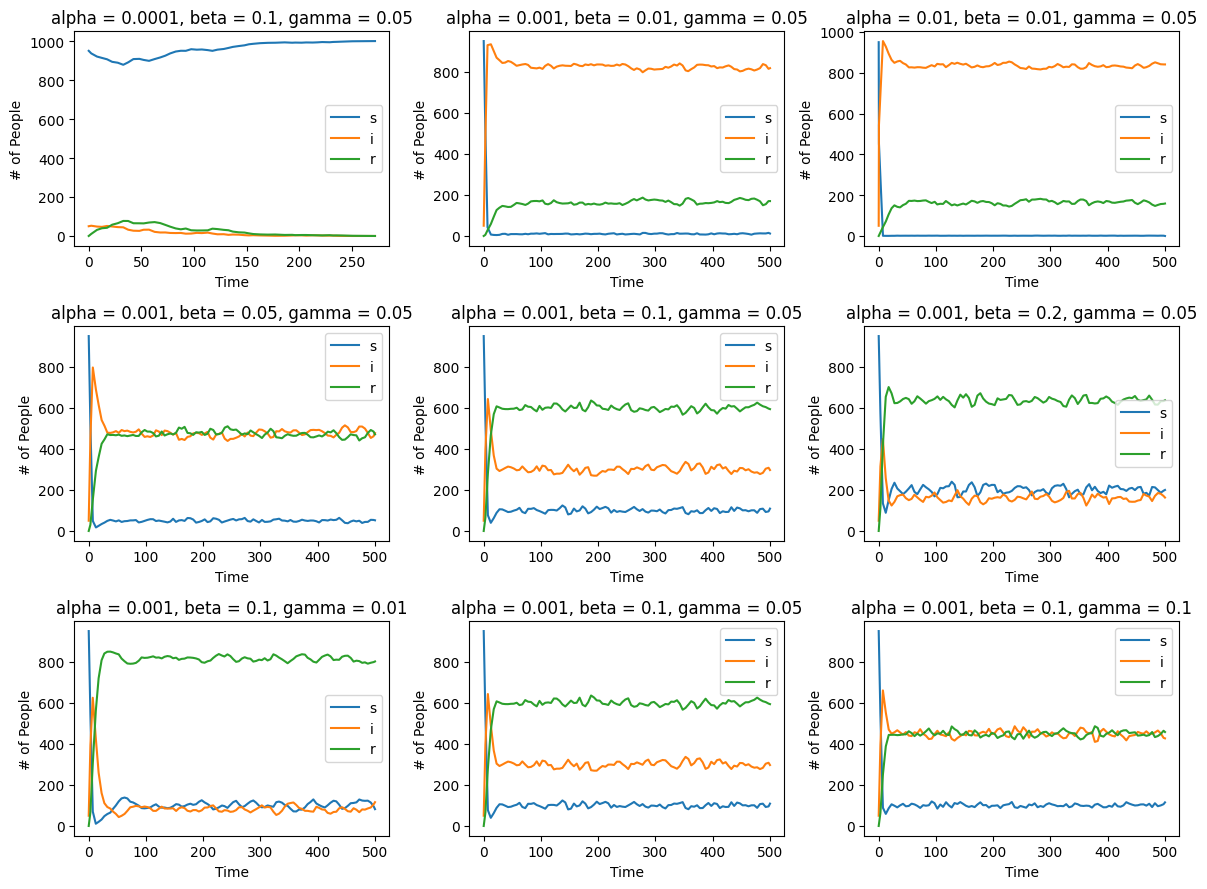

In [ ]:
population = 1000
list_rate = [[0.0001, 0.1, 0.05], [0.001, 0.01, 0.05], [0.01, 0.01, 0.05],
             [0.001, 0.05, 0.05], [0.001, 0.1, 0.05], [0.001, 0.2, 0.05],
             [0.001, 0.1, 0.01], [0.001, 0.1, 0.05], [0.001, 0.1, 0.1]]
X_0 = [int(0.95 * population), population - int(0.95 * population), 0]
rates_comparison(list_rate)

Let us once again analyze these graphs:

- In the first row, we investigate the impact of varying the infection rate ($\alpha$). Our observations indicate that for it to have a significant effect on the entire population, it must be greater than or equal to 0.001. When $\alpha$ is big enough, we see that the susceptible population experiences a sudden drop, and stabilizes around very low values, whereas the infected and recovered population stabilize in a roughly 80/20 ratio. It seems that  there are no notable changes to the behavior of the CTMC between values of $\alpha$ greater than 0.001.

- In the second row, we shift our focus to studying the effects of the recovery rate ($\beta$) on the CTMC. As this rate increases, we observe that the susceptible and recovered populations achieve a more populated stationary state, whereas the infected population converges to a lower value. Interestingly, the epidemic never completely disappears under these circumstances.

- Lastly, in the final row, we explore the influence of the susceptibility rate ($\gamma$). Our findings suggest that it primarily affects the stationary states of the recovered and infected populations: increasing the rate results in a lower convergence value for the former and a higher one for the latter. The most intriguing case arises when $\gamma = 0.1$, with both populations converging to roughly the same state. Contrary to expectations, the susceptible population remains largely unaffected, displaying no significant changes in its state. Again, the epidemic never completely disappears.

#### Population and Initial Conditions

In this subsection, we will explore the effect that modifying the total population and the initial states have on the evolution of the MC.

In [ ]:
def population_comparison(pop, perc):

    n = len(pop)
    averages = np.zeros(n).tolist()
    final = np.zeros(n).tolist()
    final_time = np.zeros(n).tolist()
    nrows = n
    fig, axes = plt.subplots(nrows= nrows, ncols= len(perc), figsize=(12, 3 * nrows))
    for i in range(n):
      for j in range(len(perc)):
        x = int(perc[j][0] * pop[i])
        y = int(perc[j][1] * pop[i])
        z = pop[i] - x - y
        X_0 = [x, y, z]

        averages[i], time = vectorized_gillespie(X_0, rates, 10, 1000)
        final[i], final_time[i] = vectorized_postprocess(averages[i], time, X_0)

        axes[i, j].plot(final_time[i], final[i][0], label='s')
        axes[i, j].plot(final_time[i], final[i][1], label='i')
        axes[i, j].plot(final_time[i], final[i][2], label='r')
        axes[i, j].set_xlabel('Time')
        axes[i, j].set_ylabel('# of People')
        axes[i, j].legend(loc = "upper right", fontsize = 8)
        axes[i, j].set_ylim(0, pop[i])

      if len(list_rate[0]) == 2:
        axes[i, j].set_title(f"alpha = {list_rate[i][0]}, beta = {list_rate[i][1]}")
      else:
        axes[i, j].set_title(f"alpha = {list_rate[i][0]}, beta = {list_rate[i][1]}, gamma = {list_rate[i][2]}")

    plt.tight_layout()
    plt.show()

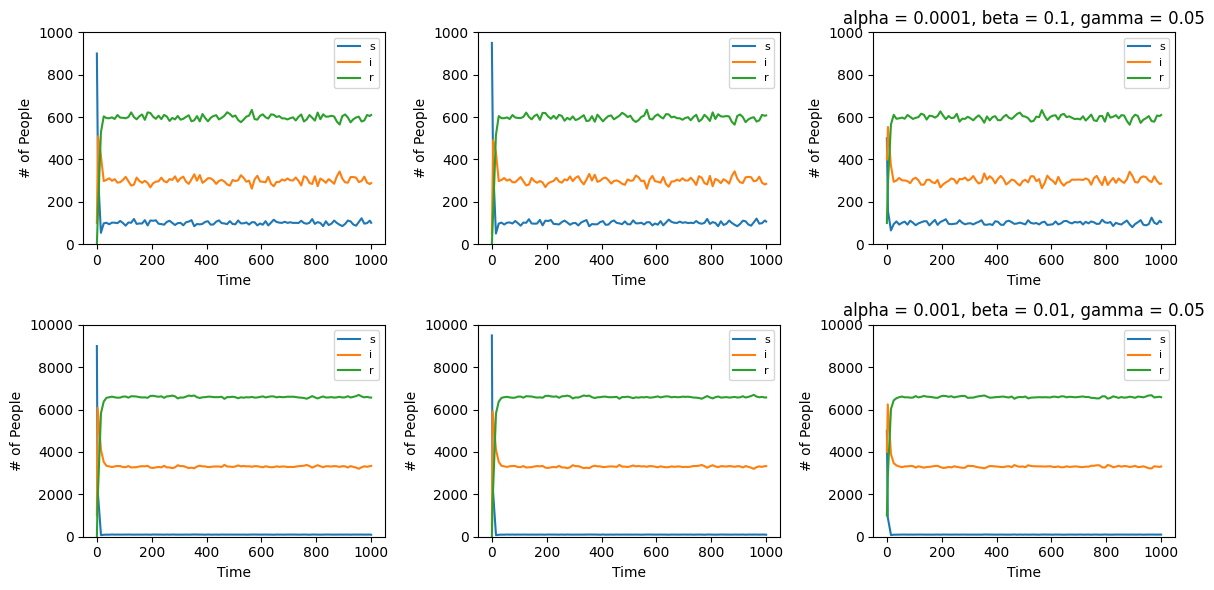

In [ ]:
rates = [0.001, 0.1, 0.05]
population_comparison([1000, 10000], [[0.9, 0.1], [0.95, 0.05], [0.5, 0.4]])

From the analysis of these graphs, two clear observations emerge:

- increasing the overall population count leads to smoother and  less noisy trajectories;
- Aligned with our expectations, the initial conditions do NOT impact the eventual converging states of the populations.



---



## Third Model: Infinite Lockdown

After having observed the behavior of the 3 interacting populations in the previous model, we have noticed that the system seems to be convering towards some stationary distribution, with some of them featuring a value $\pi_I$ fairly high.

To make our model even more realistic, we have decided to implement a lockdown mechanism to mimic how governments behaved during the COVID-19 pandemic, and it will work in the following way: if the percentage of infected people surpasses a certain threshold, then a lockdown is imposed upon the citizens, which will then be forced to stay at home for a long time.

In order to model such kind of situation, we will change the infection rate during the lockdown from $\alpha X_S X_I$ to simply $4 \alpha X_I$, to mimic the fact that each infected person will now only interact with a few people (we chose 3 because it is the mean size of a family in the US according to _Statista_).

The trigger mechanism for the lockdown is the following: we set up a switch mechanism such that if a threshold is surpassed, the switch variable goes from False to True (it can be modeled as going from 0 to 1), and if the switch is turned to true, we use the lockdown infection rate. Notice that the addition of this new variable does not change the Markovianity property of our model, since at each time the rates are determined only by the value of the switch at the previous time by the values of the populations at the previous time.

Let us once again define the model formally:
- $X(t) = (X_S(t), X_I(t), X_R(t))$ with $\sum_{k}{X_k(t)} = TOT \quad \forall t, \quad k \in \{{S, I, R}\}$
- $\alpha$ = infection rate per susceptible person per infected person
- $\beta$ = recovery rate per infected person
- $\gamma$ = susceptibility rate (more specifically rate at which recovered people become susceptible again) per recovered person
- $Q_{(i, j, k)(i', j', k')} =
  \begin{cases}
    \begin{cases}
    3 \alpha X_I & \text{if } j > threshold \text{ or switch} = 1 \\
    \alpha  X_S  X_I & otherwise
    \end{cases} & \text{if  } (i', j', k') = (i-1, j+1, k) \\
    \beta X_I & \text{if  } (i', j', k') = (i, j-1, k+1) \\
    \gamma X_R & \text{if  } (i', j', k') = (i + 1, j, k-1) \\
    0 & otherwise
  \end{cases} $


### Initialization

In [ ]:
def reaction(react):

    ds = 0
    di = 0
    dr = 0

    if react == 1:                 # Reaction 1 --> Infection
      ds = -1
      di = +1
    elif react == 2:               # Reaction 2 --> Recovery
      di = -1
      dr = 1
    elif react == 3:               # Reaction 3 --> Immunity is lost
      ds = +1
      dr = -1

    else: exit("* Wrong reaction tipe")
    X = [ds, di, dr]
    return X

In [ ]:
def vectorized_propensities(X, rates, switch, threshold):


   #Initilization of propensities list
    a = [ 0. ] * (len(rates) + 1)

    if switch:
      a[1] = 4 * X[1] * rates[0]      # Reaction from S --> I

    if not switch and X[1] > threshold * sum(X):           # Lockdown is triggered
      a[1] = 4 * X[1] * rates[0]
      switch = True

    if not switch and X[1] <= 5/10 * sum(X):
      a[1] = X[0] * X[1] * rates[0]

    a[2] = X[1] * rates[1]            # Reaction from I --> R
    a[3] = X[2] * rates[2]            # Reaction from R --> S

    a[0] = sum(a[1:])                 # Computation of a
    return a, switch

In [ ]:
# Before running fix X_0 and the rates in vector form. Make sure that the vector of rates matches the one used in the propensity function

def vectorized_gillespie(X_0, rates, total_runs, total_time, threshold):

  # Initialization
  tracker = [[[] for i in range(n_bins + 1)] for j in range(len(X_0))]   #Array to collect statistics
  t = [[] for i in range(n_bins + 1)]
  rnd.seed(42)
  bin_size = total_time/ n_bins                                                          #Setting the random seed
  switch = False

  for run in range(total_runs):


    # Setting the initial conditions
    X = X_0
    time = 0
    step = 0

    while time < total_time:

        a, switch = vectorized_propensities(X, rates, switch, threshold)
        if a[0] == 0:
          break

        tau = - log( rnd.random() ) / a[0]

        react = random_choice( a )
        dX = reaction( react )
        X = [sum(pair) for pair in zip(X, dX)]

        time = time + tau
        step = step + 1

        bin = int(time/bin_size)
        if bin > n_bins:
          bin = n_bins
        #print(bin)
        for i in range(len(X_0)):
          tracker[i][bin].append(X[i])
        t[bin].append(time)


    return tracker, t

### Exploration

In this subsection, we implement a function akin to the ones shown before, but with the addition that we can modify the threshold at which the lockdown is triggered.

In [ ]:
bin_size = 100

def update_graph_3(parameter1, parameter2, parameter3, parameter4, parameter5):
    rates = [parameter1, parameter2, parameter3]
    averages, time = vectorized_gillespie([int(0.95 * parameter4), parameter4 - int(0.95 * parameter4), 0], rates, 10, 300, parameter5)
    final, final_time = vectorized_postprocess(averages, time, [int(0.95 * parameter4), parameter4 - int(0.95 * parameter4), 0])
    fig, ax = plt.subplots()

    ax.plot(final_time, final[0], label='s')
    ax.plot(final_time, final[1], label='i')
    ax.plot(final_time, final[2], label='r')
    ax.set_xlabel('Time')
    ax.set_ylabel('# of People')
    ax.legend()
    plt.title(f'alpha = {parameter1}, beta = {parameter2}, gamma  = {parameter3}, Population = {parameter4}, Threshold = {parameter5}')
    plt.show()


# Create the interactive dropdown menus for the parameters
slider1 = widgets.FloatSlider(value=0.003, min=0.000, max=0.020, step=0.001, description= 'Alpha:')
slider2 = widgets.FloatSlider(value=0.10, min=0.000, max=0.200, step=0.001, description= 'Beta:')
slider3 = widgets.FloatSlider(value=0.010, min=0.000, max=0.200, step=0.001, description= 'Gamma:')
slider4 = widgets.FloatSlider(value=1000, min=0, max=10000, step=100, description= 'Population:')
slider5 = widgets.FloatSlider(value=0.5, min=0, max=1, step=0.1, description= 'Threshold:')

# Connect the dropdown menus to the update function
interact(update_graph_3, parameter1=slider1, parameter2=slider2, parameter3=slider3, parameter4 = slider4, parameter5 = slider5)

interactive(children=(FloatSlider(value=0.003, description='Alpha:', max=0.02, step=0.001), FloatSlider(value=…

<function __main__.update_graph_3(parameter1, parameter2, parameter3, parameter4, parameter5)>

### Analysis

In [ ]:
def rates_comparison_2(list_rate):
    n = len(list_rate)
    averages = np.zeros(n).tolist()
    final = np.zeros(n).tolist()
    final_time = np.zeros(n).tolist()
    nrows = (n + 2) // 3
    fig, axes = plt.subplots(nrows= nrows, ncols= 3, figsize=(12, 3 * nrows))
    for i in range(n):
      threshold = list_rate[i][-1]
      averages[i], time = vectorized_gillespie(X_0, list_rate[i], 10, 500, threshold)
      final[i], final_time[i] = vectorized_postprocess(averages[i], time, X_0)
      axes[i // 3, i % 3].plot(final_time[i], final[i][0], label='s')
      axes[i // 3, i % 3].plot(final_time[i], final[i][1], label='i')
      axes[i // 3, i % 3].plot(final_time[i], final[i][2], label='r')
      axes[i // 3, i % 3].set_xlabel('Time')
      axes[i // 3, i % 3].set_ylabel('# of People')
      axes[i // 3, i % 3].legend()
      axes[i // 3, i % 3].set_title(chr(945) + f" = {list_rate[i][0]}," + chr(946) + f"= {list_rate[i][1]}," + chr(947) + f"= {list_rate[i][2]}, th = {list_rate[i][3]}")

    plt.tight_layout()
    plt.show()

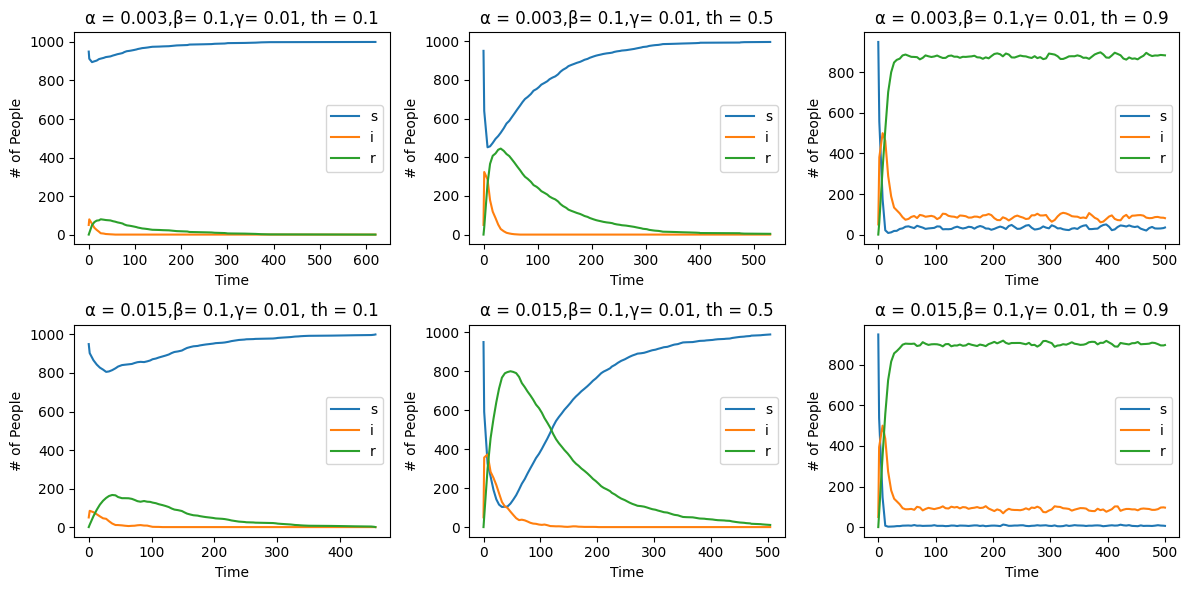

In [ ]:
population = 1000
list_rate = [[0.003, 0.1, 0.01, 0.1], [0.003, 0.1, 0.01, 0.5], [0.003, 0.1, 0.01, 0.9],
             [0.015, 0.1, 0.01, 0.1], [0.015, 0.1, 0.01, 0.5], [0.015, 0.1, 0.01, 0.9]]
X_0 = [int(0.95 * population), population - int(0.95 * population), 0]
rates_comparison_2(list_rate)

In these graphs, we examine the progression of the epidemic, varying according to different values of the infected population threshold (represented by the columns) and the infection rate (represented by the rows).

As expected, a threshold percentage value that is excessively high (for instance, 90%, as demonstrated in the third column) does not produce a noticeable impact, with the MC evolving similary to the examples seen in the model with no lockdown.

Conversely, with an extremely low threshold value (such as the 10% in the first column), the infection level within the population remains minimal, leading to the epidemic having almost no effects and vanishing quickly.

Setting the threshold percentage at 50%, as illustrated in the second column, highlights the influence of the infection rate. Indeed, as this rate increases, a larger percentage of the population becomes infected. However, the epidemic once again almost vanishes very quickly.



---



## Fourth Model: Adaptive Lockdown

To conclude our analysis, we have decided to implement a model which features an adaptive lockdown mechanism, which is surely more realistic than the previous one. In this case we leave the formal setup almost as before, but we add the fact that once the infected population drops below a certain "safety" threshold, the lockdown is ended and people can start circulating freely.

The new switch mechanism is therefore the following: the switch is initially set to 0, and if the infected population goes above the threshold it becomes 1. If the infected population falls below the safety threshold though, the switch is turned back to 0. Again Markovianity is preserved because at each step the transition rates depend on the value of the switch in the previous period, and on the values of the populations in the previous periods.

The new formal setup will therefore be the following:
- $X(t) = (X_S(t), X_I(t), X_R(t))$ with $\sum_{k}{X_k(t)} = TOT \quad \forall t, \quad k \in \{{S, I, R}\}$
- $\alpha$ = infection rate per susceptible person per infected person
- $\beta$ = recovery rate per infected person
- $\gamma$ = susceptibility rate (more specifically rate at which recovered people become susceptible again) per recovered person
- $Q_{(i, j, k)(i', j', k')} =
  \begin{cases}
    \begin{cases}
    3 \alpha X_I & \text{if } j > threshold \text{ or switch} = 1 \\
    \alpha  X_S  X_I & \text{if } j < safety \text{ or switch} = 0
    \end{cases} & \text{if  } (i', j', k') = (i-1, j+1, k) \\
    \beta X_I & \text{if  } (i', j', k') = (i, j-1, k+1) \\
    \gamma X_R & \text{if  } (i', j', k') = (i + 1, j, k-1) \\
    0 & otherwise
  \end{cases} $

### Initialization

In [ ]:
def vectorized_propensities(X, rates, switch, threshold, safety):


   #Initilization of propensities list
    a = [ 0. ] * (len(rates) + 1)

    if switch:
      a[1] = 4 * X[1] * rates[0]      # Reaction from S --> I

    if not switch and X[1] > threshold * sum(X):       # Lockdown is triggered
      a[1] = 4 * X[1] * rates[0]
      switch = True

    if not switch and X[1] <= 5/10 * sum(X):
      a[1] = X[0] * X[1] * rates[0]

    if switch and X[1] <= safety * sum(X):            # Lockdown is ended
      a[1] = X[0] * X[1] * rates[0]
      switch = False

    a[2] = X[1] * rates[1]            # Reaction from I --> R
    a[3] = X[2] * rates[2]            # Reaction from R --> S

    a[0] = sum(a[1:])                 # Computation of a
    return a, switch

In [ ]:
# Before running fix X_0 and the rates in vector form. Make sure that the vector of rates matches the one used in the propensity function

def vectorized_gillespie(X_0, rates, total_runs, total_time, threshold, safety):

  # Initialization
  tracker = [[[] for i in range(n_bins + 1)] for j in range(len(X_0))]                   #Array to collect statistics
  t = [[] for i in range(n_bins + 1)]
  rnd.seed(42)
  bin_size = total_time/ n_bins                                                          #Setting the random seed
  switch = False

  for run in range(total_runs):


    # Setting the initial conditions
    X = X_0
    time = 0
    step = 0

    while time < total_time:

        a, switch = vectorized_propensities(X, rates, switch, threshold, safety)
        if a[0] == 0:
          break

        tau = - log( rnd.random() ) / a[0]

        react = random_choice( a )
        dX = reaction( react )
        X = [sum(pair) for pair in zip(X, dX)]

        time = time + tau
        step = step + 1

        bin = int(time/bin_size)
        if bin > n_bins:
          bin = n_bins
        #print(bin)
        for i in range(len(X_0)):
          tracker[i][bin].append(X[i])
        t[bin].append(time)


    return tracker, t

### Exploration

In the following subsection we once again implement a function to create an interactive graph, and this time the interactive parameters are:
- $\alpha$
- $\beta$
- $\gamma$
- $TOT$ (i.e. the population size)
- $th$ (i.e. the threshold value)
- $safety$ (i.e. the safety value)

This time the Gillespie Algorithm will perform 10 runs of 300 iterations each.

In [ ]:
bin_size = 100

def update_graph_4(parameter1, parameter2, parameter3, parameter4, parameter5, parameter6):
    rates = [parameter1, parameter2, parameter3]
    averages, time = vectorized_gillespie([int(0.95 * parameter4), parameter4 - int(0.95 * parameter4), 0], rates, 10, 300, parameter5, parameter6)
    final, final_time = vectorized_postprocess(averages, time, [int(0.95 * parameter4), parameter4 - int(0.95 * parameter4), 0])
    fig, ax = plt.subplots()

    ax.plot(final_time, final[0], label='s')
    ax.plot(final_time, final[1], label='i')
    ax.plot(final_time, final[2], label='r')
    ax.set_xlabel('Time')
    ax.set_ylabel('# of People')
    ax.legend()
    plt.title(f'alpha = {parameter1}, beta = {parameter2}, gamma  = {parameter3}, Population = {parameter4}, Threshold = {parameter5}')
    plt.show()


# Create the interactive dropdown menus for the parameters
slider1 = widgets.FloatSlider(value=0.003, min=0.000, max=0.020, step=0.001, description= 'Alpha:')
slider2 = widgets.FloatSlider(value=0.10, min=0.000, max=0.200, step=0.001, description= 'Beta:')
slider3 = widgets.FloatSlider(value=0.010, min=0.000, max=0.200, step=0.001, description= 'Gamma:')
slider4 = widgets.FloatSlider(value=1000, min=0, max=10000, step=100, description= 'Population:')
slider5 = widgets.FloatSlider(value=0.5, min=0, max=1, step=0.1, description= 'Threshold:')
slider6 = widgets.FloatSlider(value=0.2, min=0, max=1, step=0.1, description= 'Safety:')

# Connect the dropdown menus to the update function
interact(update_graph_4, parameter1=slider1, parameter2=slider2, parameter3=slider3, parameter4 = slider4, parameter5 = slider5, parameter6 = slider6)

interactive(children=(FloatSlider(value=0.003, description='Alpha:', max=0.02, step=0.001), FloatSlider(value=…

<function __main__.update_graph_4(parameter1, parameter2, parameter3, parameter4, parameter5, parameter6)>

### Analysis

This graph appears quite noisy initially. However, by manipulating the parameter values, an almost periodic pattern begins to emerge.

This behavior aligns with our expectations, as explained in the above description. We continually introduce and remove the lockdown mechanism, and each time, the populations attempt to follow a specific trajectory determined by the rates. They try to reach their convergence values, but we interrupt this process each time by altering the lockdown parameter, causing them to repeat this cyclical rise and fall pattern.



---



## Conclusion

In conclusion, in this project we have analyzed several different epidemiological models, ranging from a very simple SIR model implementation to more elaborated models with adaptive lockdown mechanisms.

In all of the models, the results that we obtained by varying the rates were the ones we were expecting. Increasing the infection rates generally increased the peak number of infections and decreased the time necessary to reach the infection peak; increasing the recovery rate increased the speed at which the population recovered, and in extreme cases even prevented the epidemic from spreading. It was interesting to notice that in many models, the number of suscepible people was almost always very low after a short time, and all the population was partitioned between infected and recovered people.

We have also noticed that most of our models converged towards stationary distributions, with the first simple model obviously converging towards the state $(0, 0, TOT)$ since people's immunity was long lasting, and the other basic (with no lockdown) SIR model also converging towards stationarity (albeit with different ratios). The model with the infinite lockdown mechanism also converged to stationarity as expected, with the population completely healing and becoming susceptible again, whereas the model with the adaptive lockdown did not converge because its rates kept changing.

Some possible future extensions of this model could be investigating what happens to the evolution of the MC if we add births, deaths and immigration to the possible reactions, as well as creating more different populations, like for instance "asymptomatic infected" people and "symptomatic infected" people, as well as "hospitalized" people.